In [10]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [11]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

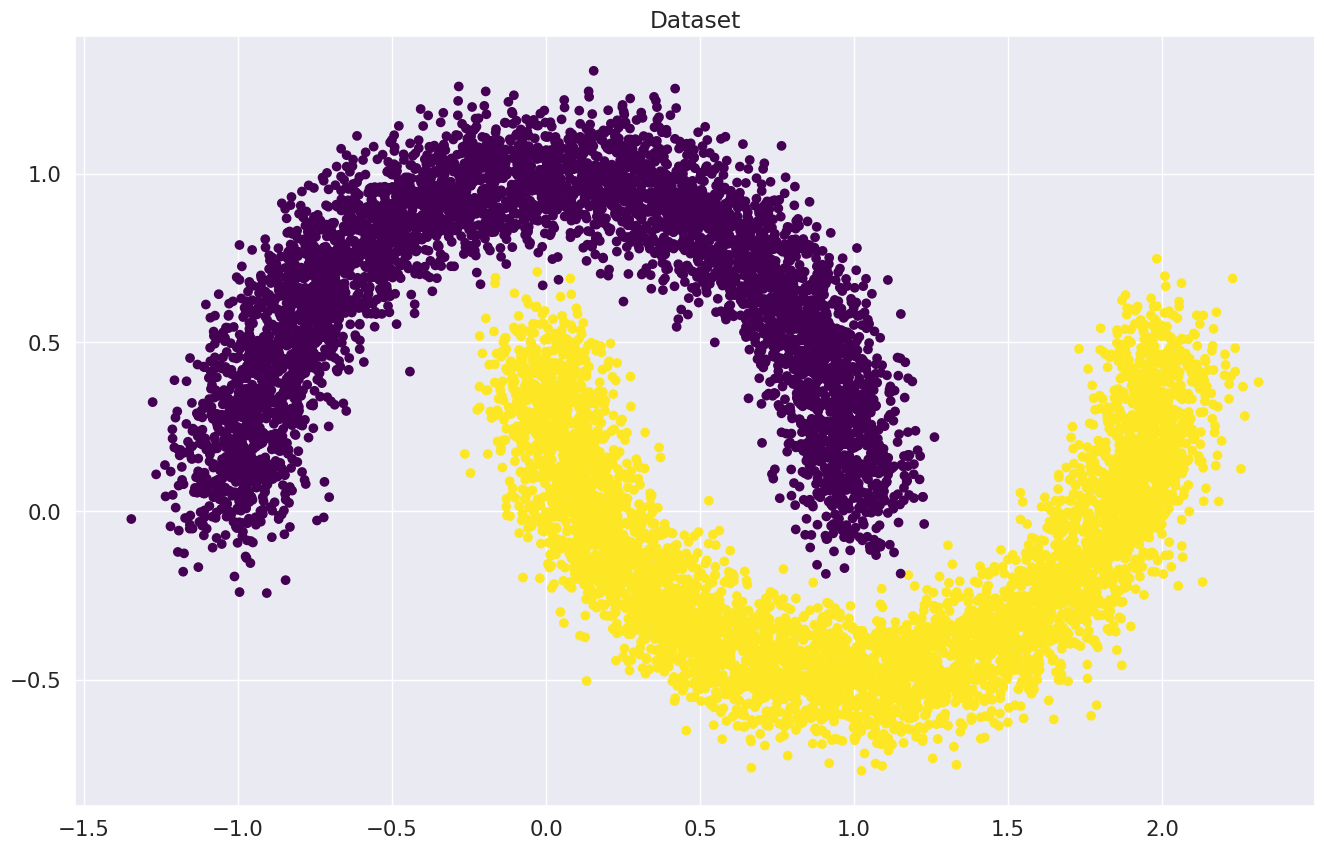

In [12]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Создадим тензоры с обучающими и тестовыми данными

In [14]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)

In [15]:
X_train_t = X_train_t.to(torch.float32)
y_train_t = y_train_t.to(torch.float32)
X_val_t = X_val_t.to(torch.float32)
y_val_t = y_val_t.to(torch.float32)

Создаем `Dataset` и `DataLoader`.

In [17]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Реализация логистической регрессии

Напишем модуль на PyTorch, реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear`. Веса инициализируем нормальным распределением (`torch.randn`).

In [18]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [19]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

### Train loop

Вот псевдокод, описывающий процесс обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Реализация цикла обучения

In [20]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp[:, 0], y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4375
Iteration: 100
Batch accuracy: 0.859375
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 578.Convergence. Stopping iterations.


### Визуализируем результаты

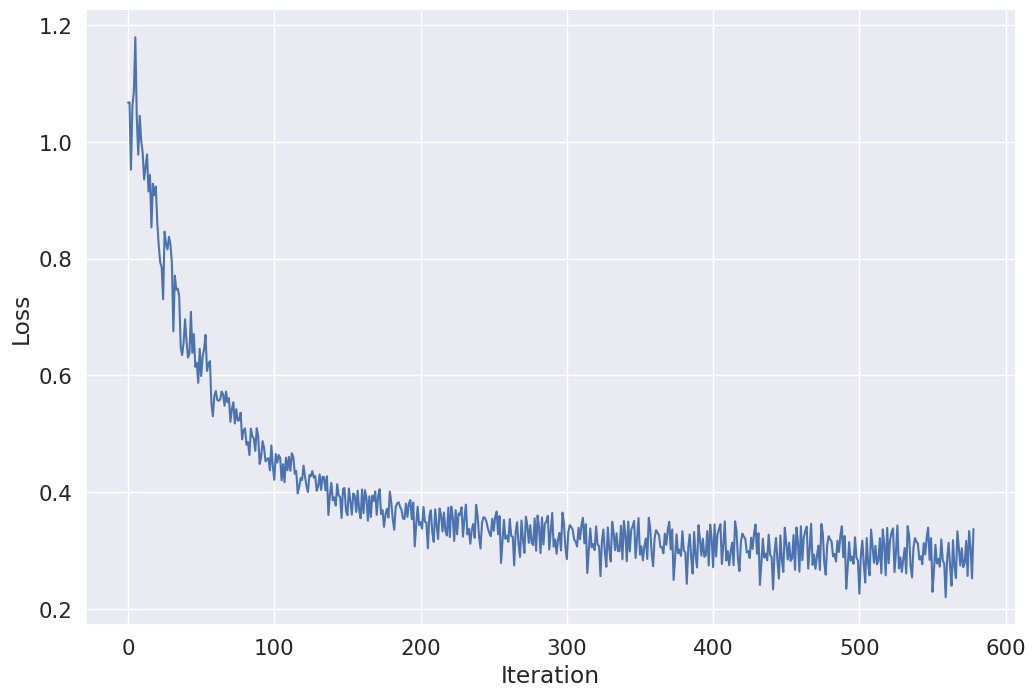

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

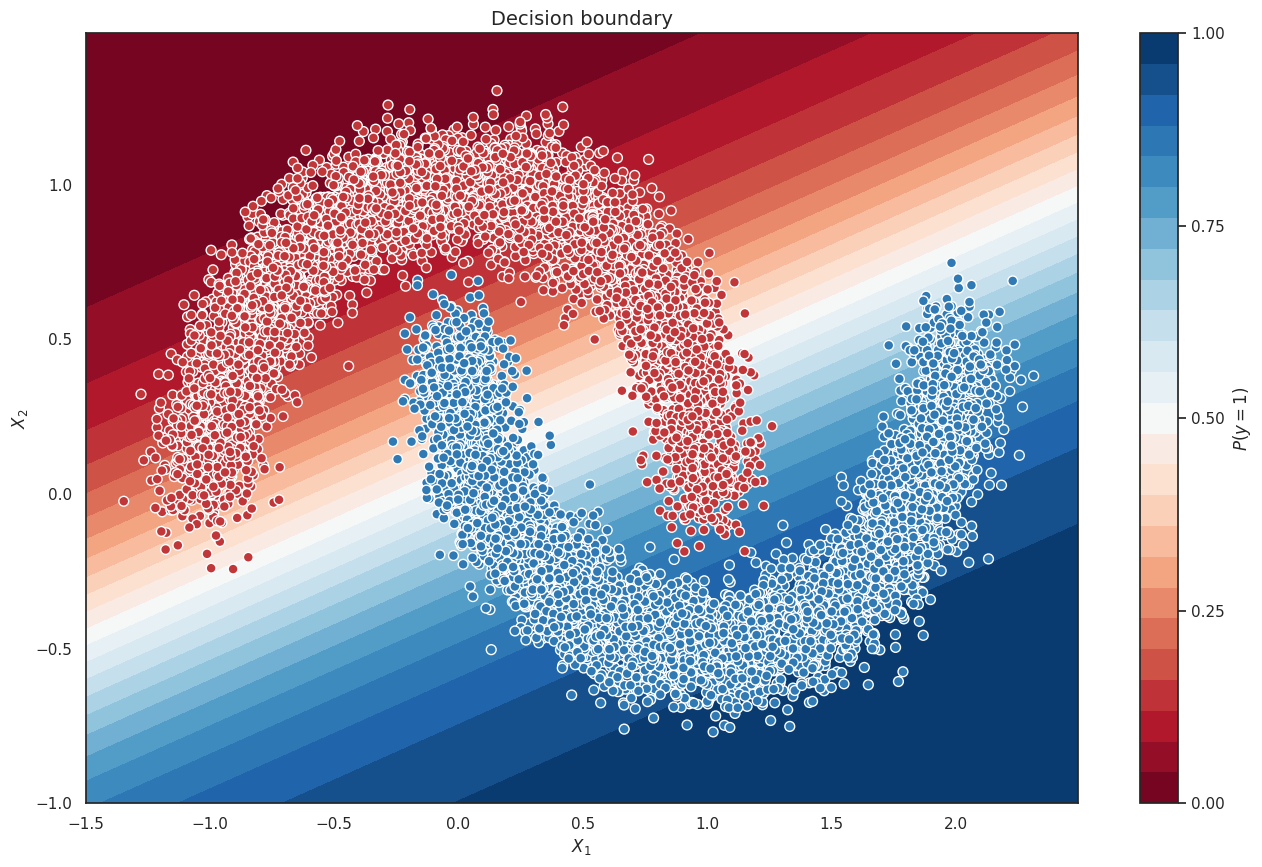

In [22]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Реализуем predict и посчитаем accuracy на test.

In [23]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [24]:
from sklearn.metrics import accuracy_score

accuracy_score(predict(val_dataloader, linear_regression), y_val_t)

0.8808

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы.

In [25]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 154125683.01it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21516109.03it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 51484340.03it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17302932.58it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [26]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Простая полносвязная нейронная сеть

Создадим полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

В качестве лосса возьмем кросс-энтропию


In [27]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 10)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Обучение

In [30]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()  # <------------------ переводим модель в режим train
                 optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                 outp = model(x_batch)
                 loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                 loss.backward()  # <--------------- считаем градиенты
                 optimizer.step()
            else:
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            preds = outp.argmax(-1)
            correct = sum(preds == y_batch)
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.873581063034188
Loader: valid. Accuracy: 0.9217748397435898
Epoch: 2
Loader: train. Accuracy: 0.9304387019230769
Loader: valid. Accuracy: 0.9470152243589743
Epoch: 3
Loader: train. Accuracy: 0.9509381677350427
Loader: valid. Accuracy: 0.9575320512820513
Epoch: 4
Loader: train. Accuracy: 0.9627069978632479
Loader: valid. Accuracy: 0.9611378205128205
Epoch: 5
Loader: train. Accuracy: 0.9689837072649573
Loader: valid. Accuracy: 0.9647435897435898
Epoch: 6
Loader: train. Accuracy: 0.9736912393162394
Loader: valid. Accuracy: 0.9649439102564102
Epoch: 7
Loader: train. Accuracy: 0.9775974893162394
Loader: valid. Accuracy: 0.9646434294871795
Epoch: 8
Loader: train. Accuracy: 0.9805355235042735
Loader: valid. Accuracy: 0.9638421474358975
Epoch: 9
Loader: train. Accuracy: 0.9830061431623932
Loader: valid. Accuracy: 0.9669471153846154
Epoch: 10
Loader: train. Accuracy: 0.9852263621794872
Loader: valid. Accuracy: 0.9703525641025641


### Протестируем разные функции активации.
Попробуем разные функции активации. Для каждой функции активации заполним массив validation accuracy.

In [36]:
def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    )
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()  # <------------------ переводим модель в режим train
                    optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                    loss.backward()  # <--------------- считаем градиенты
                    optimizer.step()
                else:
                    model.eval()  # <------------------ переводим модель в режим eval
                    with torch.no_grad():  # <--------- НЕ считаем градиенты
                        outp = model(x_batch)  # <------------- получаем "логиты" из модели
                preds = outp.argmax(-1)
                correct = sum(preds == y_batch)
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [37]:
elu_accuracy = accuracy["valid"]

In [38]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

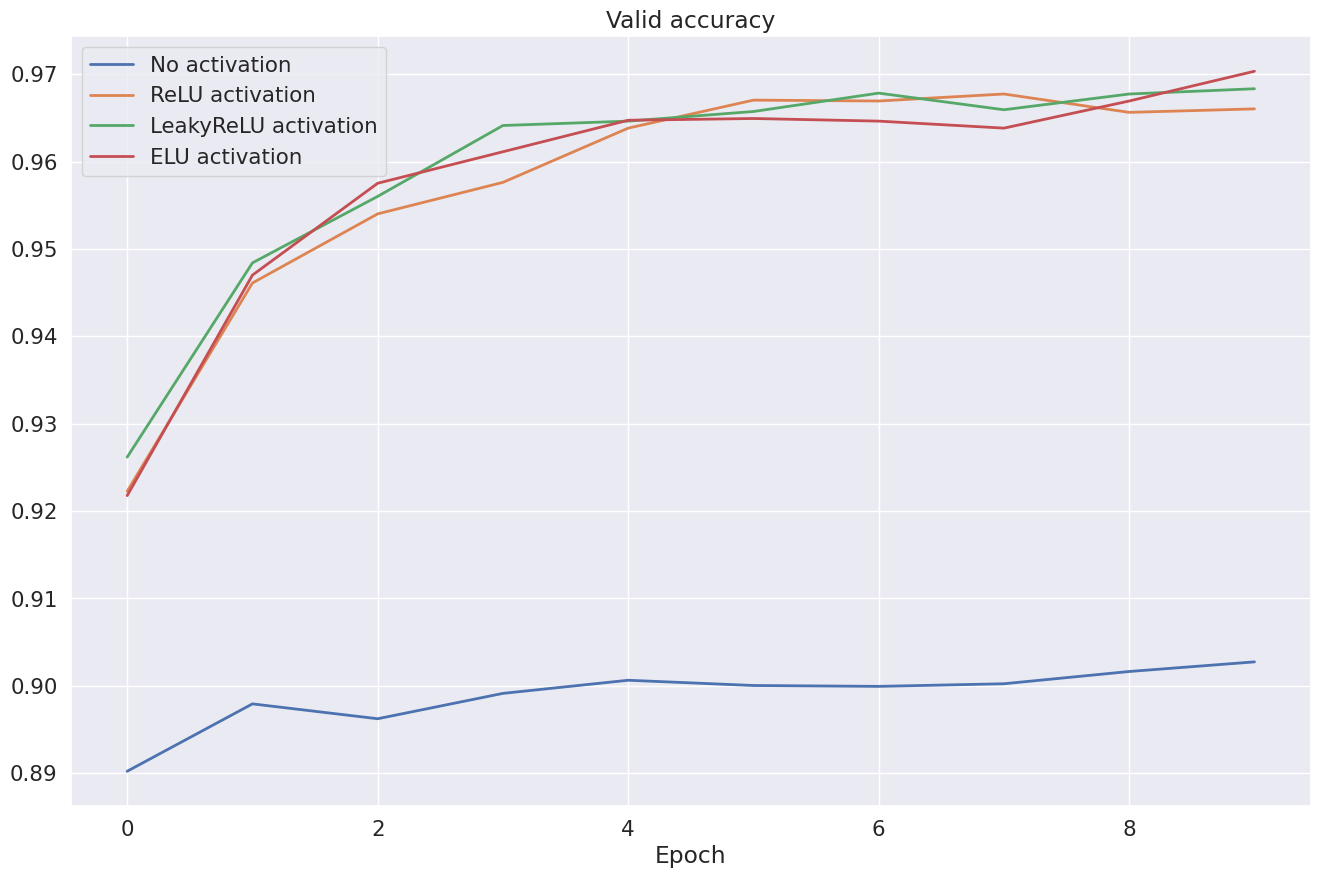

In [39]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Часть 2.2 Сверточные нейронные сети

### Реализуем LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуем архитектуру LeNet, предложенную еще в 1998 году.

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [40]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучение CNN


In [42]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()  # <------------------ переводим модель в режим train
                 optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                 outp = model(x_batch)
                 loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                 loss.backward()  # <--------------- считаем градиенты
                 optimizer.step()
            else:
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            preds = outp.argmax(-1)
            correct = sum(preds == y_batch)
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8936131143162394
Loader: valid. Accuracy: 0.9620392628205128
Epoch: 2
Loader: train. Accuracy: 0.9678819444444444
Loader: valid. Accuracy: 0.9732572115384616
Epoch: 3
Loader: train. Accuracy: 0.9774639423076923
Loader: valid. Accuracy: 0.9797676282051282
Epoch: 4
Loader: train. Accuracy: 0.9832899305555556
Loader: valid. Accuracy: 0.9820713141025641
Epoch: 5
Loader: train. Accuracy: 0.986595219017094
Loader: valid. Accuracy: 0.9825721153846154
Epoch: 6
Loader: train. Accuracy: 0.9883981036324786
Loader: valid. Accuracy: 0.9830729166666666
Epoch: 7
Loader: train. Accuracy: 0.9900340544871795
Loader: valid. Accuracy: 0.9831730769230769
Epoch: 8
Loader: train. Accuracy: 0.9916199252136753
Loader: valid. Accuracy: 0.9837740384615384
Epoch: 9
Loader: train. Accuracy: 0.9930221688034188
Loader: valid. Accuracy: 0.9853766025641025
Epoch: 10
Loader: train. Accuracy: 0.9933059561965812
Loader: valid. Accuracy: 0.9849759615384616


In [43]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

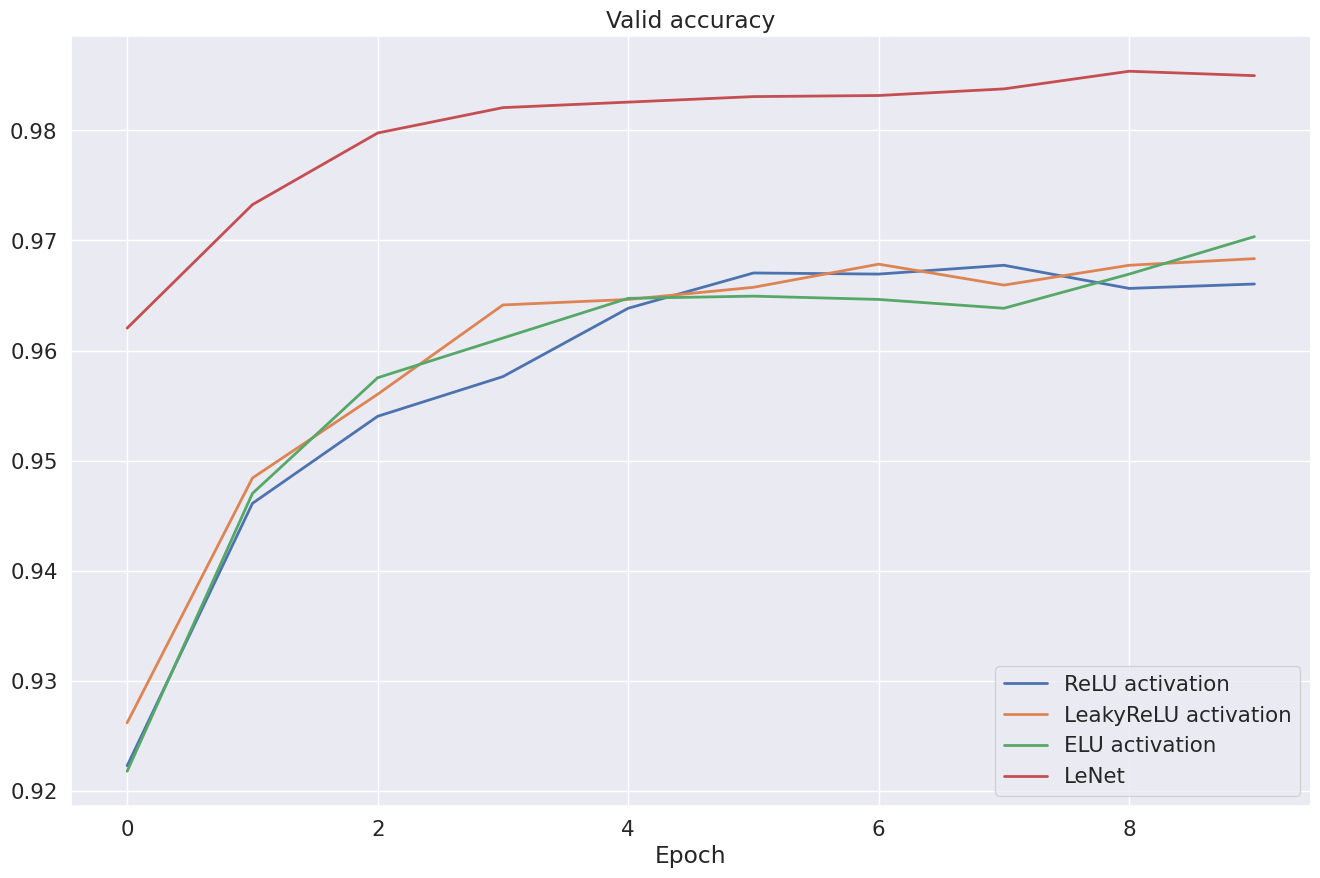

In [44]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()